In [88]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
lm = LinearRegression()

import statsmodels.api as sm

#Load our two Data Frames
AmesDummies = pd.read_csv('AmesDummies.csv')
AmesDummiesOrdinal = pd.read_csv('AmesDummiesOrdinal.csv')

In [89]:
#Load the Forward Selection DF, which contains the list of Features to include in the linear model:
AmesFeatureDF = pd.read_csv('AmesDummiesForwardAICList.csv')

In [90]:
OriginalList = list(AmesFeatureDF['CreatedFeatures'])

In [91]:
OriginalList.remove('PoolArea')

In [92]:
OriginalList.append('PoolQC')

In [93]:
OriginalList.append('GarageType_No')

In [94]:
#Trim AmesDummiesOrdinal to a DF containing only the selected Features:
AmesDF = pd.concat([AmesDummiesOrdinal[OriginalList],AmesDummiesOrdinal[['SalePrice']]], axis=1)
AmesDF.shape

(1458, 66)

In [95]:
#Transform AmesDF into the Train AmesDF
np.random.seed(19)
testIdxes = np.random.choice(range(1458), size=292, replace=False)
trainIdxes = list(set(range(1458))-set(testIdxes))

AmesDF2 = AmesDF.copy()
AmesDF = AmesDF.iloc[trainIdxes,]
AmesDFTest = AmesDF2.iloc[testIdxes,]

In [96]:
#As we can see, the trimmed DF has 120 total features removed, for a total of 67:
print(AmesDummiesOrdinal.shape)
print(AmesDF.shape)

AmesDF.index = range(1166)

(1458, 187)
(1166, 66)


In [97]:
#Initiate K-fold (n=5) cross-validation model to train/test:

import sklearn.model_selection as ms
ms_k5 = ms.KFold(n_splits=5, shuffle=True)

In [98]:
#Perform separate train/test validation runs for each of the 5 K-fold groups:

#Create X and Y variables
X = AmesDF.drop('SalePrice', axis=1)
Y = AmesDF['SalePrice']

#Rename the true (20% untouched) test DFs
testX = AmesDFTest.drop('SalePrice', axis=1)
testY = AmesDFTest['SalePrice']

#Instantiate the K-fold generator object:
np.random.seed(0)
AmesDF5Fold = ms_k5.split(AmesDF.drop('SalePrice', axis=1), AmesDF['SalePrice'])

#Produce list of test R^2 scores, and Actual vs Predicted lists for the individual runs
R2List = []
PredictList = []
ActualList = []
PureTestR2 = []
RMSLE = []
CoefsDFLinear = pd.DataFrame()

for train, test in AmesDF5Fold:
    
    #Run the fit using the train data for each K
    lm.fit(X.iloc[train,], Y[train])
    #Run your predicion for the "missing" K-part
    p = lm.predict(X.iloc[test,])
    #Check your schore for the missing K-part
    R2 = lm.score(X.iloc[test,], Y[test])
    #Run a test on the completely untouched test 20%
    TestR2 = lm.score(testX, testY)
    
    #Append these scores to the lists above
    R2List.append(R2)
    PureTestR2.append(TestR2)
    PredictList.append(p)
    ActualList.append(Y[test])
    
    #Make predictions for the completely untouched 20%
    PredictionsTest = lm.predict(testX)
    
    #Use these predictions to calculate RMSLE for the untouched 20% and append
    RMSLEvalue = np.sqrt(np.mean(np.power(np.log1p(testY)-np.log1p(PredictionsTest), 2)))
    RMSLE.append(RMSLEvalue)
    
    #Make a DF of predicted coefficients from each of the five runs
    CoefsDFLinear = pd.concat([CoefsDFLinear, pd.DataFrame({'Linear': pd.Series(lm.coef_)})], axis=1)
    
CoefsDFLinear.index = OriginalList

In [99]:
CoefsDFLinear.head()

,Linear,Linear,Linear,Linear,Linear
OverallQual,7002.110741,7932.788993,7810.175497,7664.651798,6349.983738
TotalSF,72.355721,71.932564,75.697162,67.960881,63.143243
TotalBsmtSF,14.847893,17.080434,14.804422,16.657963,24.684734
KitchenQual,5489.258929,7243.339846,7538.018343,7310.917224,9739.093696
BsmtExposure,4936.987281,5684.770080,5540.417643,5767.411578,4465.930225


In [100]:
#Export the 5 K-fold-derived sets of linear coefficients to combine with our RF and XGBoost values:
CoefsDFLinear.to_csv('CoefsDFLinear.csv')

In [101]:
#What are the R^2 scores for each of our 5 runs?
print(R2List)
print(PureTestR2)
print(RMSLE)

[0.8625737018825145, 0.9116200103516651, 0.9246922639964359, 0.854818048225745, 0.8675657505449511]
[0.8807937945168949, 0.896130712123903, 0.884882147169131, 0.8887943873280119, 0.8862197796970307]
[0.14433525016650633, 0.1426710192180993, 0.14592638417410475, 0.14206553728551027, 0.14773026097670422]


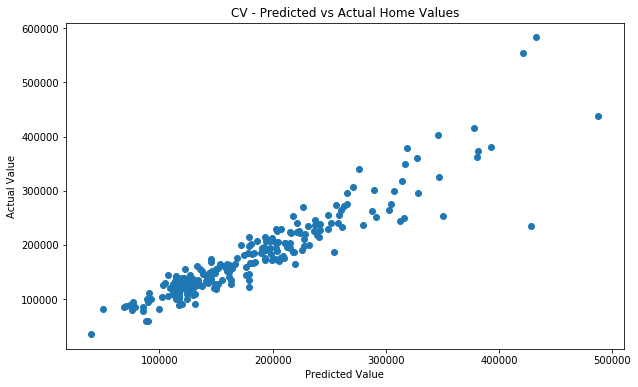

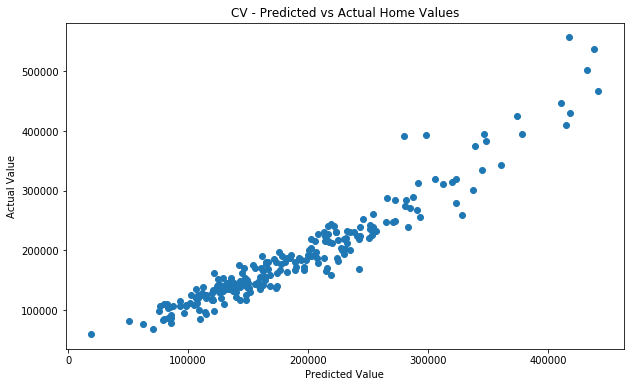

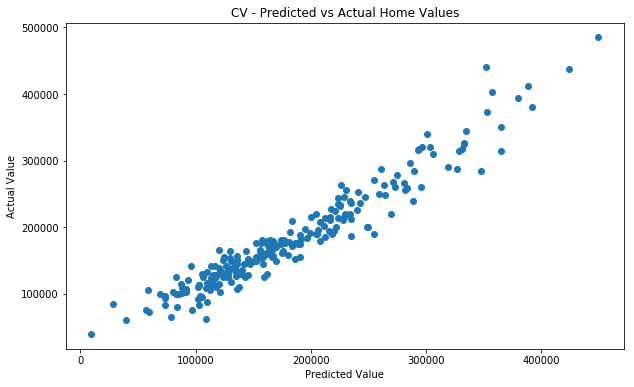

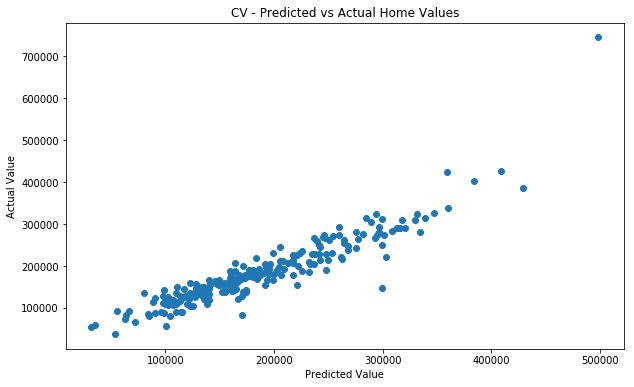

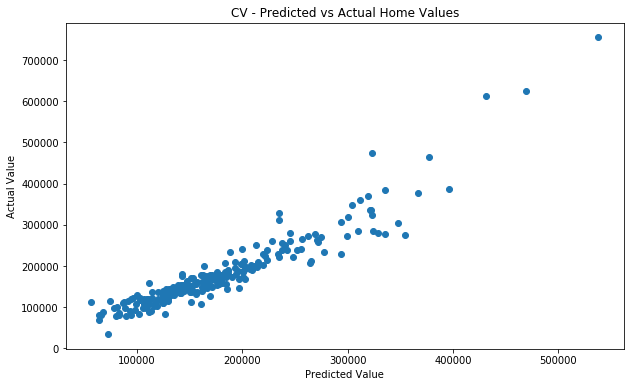

In [102]:
#Plot the predicted vs actual 'SalePrice' values for each of the 5 runs:
import matplotlib.pyplot as plt

for i in range(len(PredictList)):

    plt.figure(figsize=(10,6))
    plt.scatter(PredictList[i], ActualList[i])
    plt.xlabel('Predicted Value')
    plt.ylabel('Actual Value')
    plt.title('CV - Predicted vs Actual Home Values')   
    plt.show()

In [103]:
#Just out of curiousity, what would this look like for only 2 folds (50/50 split between groups?)
ms_k2 = ms.KFold(n_splits=2, shuffle=True)

#Perform separate train/test validation runs for each of the 5 K-fold groups:

#Create X and Y variables
X = AmesDF.drop('SalePrice', axis=1)
Y = AmesDF['SalePrice']

testX = AmesDFTest.drop('SalePrice', axis=1)
testY = AmesDFTest['SalePrice']

#Instantiate the K-fold generator object:
np.random.seed(0)
AmesDF2Fold = ms_k2.split(AmesDF.drop('SalePrice', axis=1), AmesDF['SalePrice'])

#Produce list of test R^2 scores, and Actual vs Predicted lists for the individual runs
R2ListN2 = []
PredictListN2 = []
ActualListN2 = []
PureTestR2N2 = []

for train, test in AmesDF2Fold:
    lm.fit(X.iloc[train,], Y[train])
    p = lm.predict(X.iloc[test,])
    R2 = lm.score(X.iloc[test,], Y[test])
    TestR2 = lm.score(testX, testY)
    R2ListN2.append(R2)
    PureTestR2N2.append(TestR2)
    PredictListN2.append(p)
    ActualListN2.append(Y[test])

In [104]:
#What are the R^2 scores for each of our 2 runs? Still a fairly good 79% and 86% R^2 value.
print(R2ListN2)
print(PureTestR2N2)

[0.8743955029047651, 0.8704272872508203]
[0.8730478932831938, 0.8826745180834922]


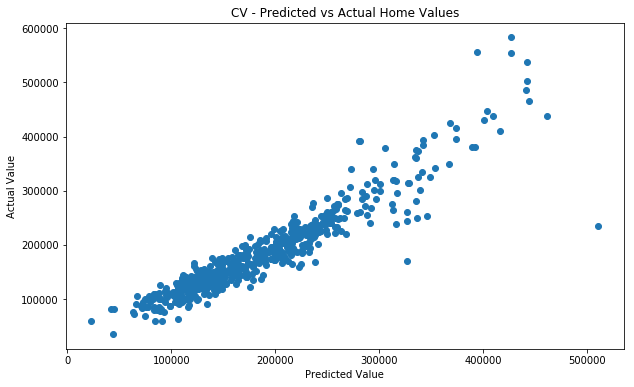

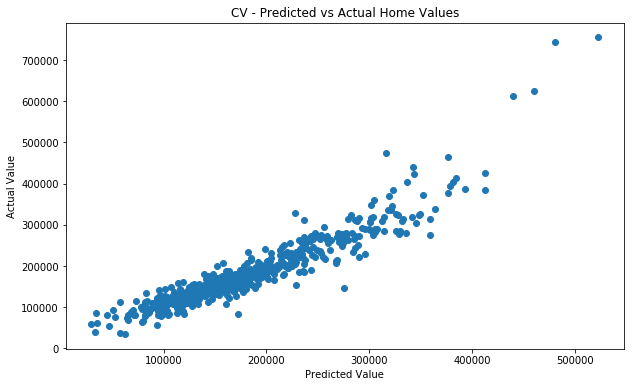

In [105]:
#Let's plot these:
for i in range(len(PredictListN2)):

    plt.figure(figsize=(10,6))
    plt.scatter(PredictListN2[i], ActualListN2[i])
    plt.xlabel('Predicted Value')
    plt.ylabel('Actual Value')
    plt.title('CV - Predicted vs Actual Home Values')
    plt.show()